In [1]:
#csv desde drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq as hq
from keras import backend as K

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, GRU, Dropout, RepeatVector, CuDNNGRU, Conv1D, Flatten, SimpleRNN
from keras.optimizers import Adam, SGD

from sklearn.metrics import mean_squared_error
import math

Using TensorFlow backend.


Se generan funciones para determinar que dias corresponder a cyber days.

In [0]:
more_days = [1, 3, 5, 6, 7, 9, 12]

def sum_day(day, month, year):
    day = day + 1
    if day == 29:
        if month == 2:
            day = 1
            month += 1
    elif day == 31:
        if month not in more_days:
            day = 1
            month += 1
    elif day == 32:
        if month == 12:
            day = 1
            month = 1
            year += 1
        else:
            day = 1
            month += 1
    
    return [day, month, year]
  
def in_sale(day, month, year):
    if year == 2017:
        if month == 5:
            if day in [29, 30, 31]:
                return 1
        if month == 11:
            if day in [6, 7, 8]:
                return 1
    if year == 2018:
        if month == 5:
            if day in [28, 29, 30]:
                return 1
        if month == 10:
            if day in [8, 9, 10]:
                return 1
    return 0

Luego, se seleccionan los 4 productos mas vendidos a lo largo de los dos años de datos.

In [4]:
#Notice that there's a peak at the end, that could mean that during that time there was a special offer like a cyberday
#It could be a good idea to create a feature that determines if we are on a sale day or not (1 or 0)

values = list()
day_counter = 0

items = {4385959, 168757, 2678016, 4695904}
items_data = {item: [0, 0] for item in items}

day_number, month, year = 1, 1, 2017
#Most selled items ids 4385959, 168757, 2678016, 4695904
#We create our dataset by saving 2 values, times bought in the day and how much did we earn from it
with open('drive/My Drive/Colab Notebooks/costanera2.csv', 'r') as istream:
    for line in istream:
        if line == '\n': continue
        day = list()
        for tup in line.split(';'):
            id_prod, y, z = tuple(map(int, tup.split(',')))
            #Instead of just looking for 1 item, we need to do it for 4
            if id_prod in items:
                items_data[id_prod][0] += y
                items_data[id_prod][1] += z*y
        day.append(in_sale(day_number, month, year))
        for item in items:
            day.append(items_data[item][0])
            day.append(items_data[item][1])
        values.append(day)
        items_data = {item: [0, 0] for item in items}
        date = sum_day(day_number, month, year)
        day_number = date[0]
        month = date[1]
        year = date[2]

#We save our data into a dataframe to easily manage it                
df = pd.DataFrame(data=np.asarray(values), columns=['sale', 'count0', 'money0', 'count1', 'money1', 'count2', 'money2', 'count3', 'money3'], dtype='float32')
df.head()

,sale,count0,money0,count1,money1,count2,money2,count3,money3
0,0.0,9.0,1165995.0,13.0,38714.0,264.0,48048.0,45.0,598140.0
1,0.0,3.0,189000.0,5.0,14950.0,264.0,29304.0,43.0,519010.0
2,0.0,6.0,552996.0,6.0,17940.0,273.0,45045.0,72.0,974376.0
3,0.0,5.0,269000.0,3.0,8970.0,273.0,56784.0,60.0,780600.0
4,0.0,0.0,0.0,5.0,14950.0,293.0,143863.0,83.0,1024303.0


Es necesario destacar un dato muy importante al momento de realizar esto, dado que los productos solo se seleccionaron por su frecuencia de compras y no por su relación es posible que los datos que aparescan en el dataset no tengan ningún tipo de asociación lo que al final significara un ruido para el modelo al momento de entrenar, se intento buscar productos relacionados entre si, pero la cantidad de productos que posee falabella es muy extensa y su variedad a veces puede significar que se tiene menos registros de ventas. Ademas de probar con los productos seleccionados se intento con familiar de productos como por ejemplo ropa de mujer, zapatos, calcetines etc, o con nintendo switch + joycon + bolso generico + algun juego, pero la cantidad de ventas realizadas eran muy pocas por lo que el modelo tendia a predecir solo 0.

Se muestran los boxplots de cada atributo guardado en el dataset, estos corresponden a cantidad del producto x vendida y cantidad de dinero ganado en promedio al dia por dicho producto ademas de un atributo que determina si se encuentran en cyberdays o no.

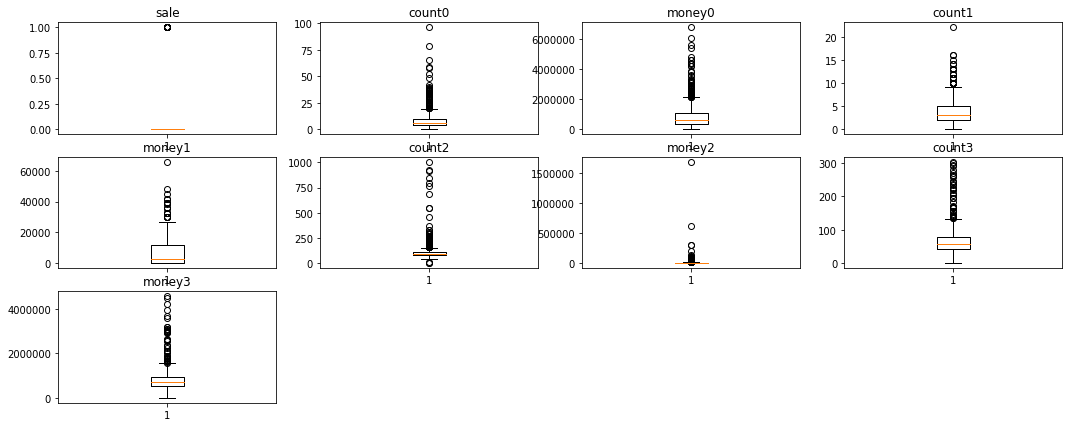

In [5]:
columns_names = df.columns.values
plt.figure(figsize=(18, 7))

for i in range(len(columns_names)):
    plt.subplot(3, 4, i+1)
    plt.boxplot(df[columns_names[i]].values)
    plt.title(columns_names[i])
    
plt.show()

Se separan los conjuntos entre datos para entrenamiento y datos para validación.

In [6]:
#We separate our data into train and test data
#500 days will be for training and 215 for testing
trainData = df[:635]
testData = df[635:]

print(len(trainData), len(testData))

635 80


Se opta por utilizar un escalador estandard porque se asume que el modelo logre determinar las ventas que se esperan para dias como cyberdays.

In [0]:
#Dropping money cause we wont use it in this example (but it could be used)
trainData = trainData.drop(['money0', 'money1', 'money2', 'money3'], axis=1)
testData = testData.drop(['money0', 'money1', 'money2', 'money3'], axis=1)

#trainData = trainData.drop(['money0', 'count1', 'count2', 'count3', 'money1', 'money2', 'money3'], axis=1)
#testData = testData.drop(['money0', 'count1', 'count2', 'count3', 'money1', 'money2', 'money3'], axis=1)

forPreds = trainData.copy()
#forPreds = forPreds.drop(['sale', 'money0', 'money1', 'money2', 'money3'], axis=1)
forPreds = forPreds.drop(['sale'], axis=1)

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler

#Scaling our values (including this must includes the values that will be in the 'y' dataset)
scaler = StandardScaler()
scaler.fit(trainData)

scaler2 = StandardScaler()
scaler2.fit(forPreds)

train_data_scaled = scaler.transform(trainData)
test_data_scaled = scaler.transform(testData)

Se genera una función para obtener las series de tiempo a utilizar en los modelos.

In [0]:
#Here is were we create our dataset
#X will have a lag of 20 days, meaning that it will contain (in separate features) how many items of product 0 were sold in the day
#Y will have just 1 value (1 per item) where it will contain how many items of product were sold in 30 days after the final day of X

#This should look like this with a lag of 3
# [x            | y ]
# [13   30    12| 20]
# [30   12    11| 23]

#Notice that after 30 days have passed the first value of X will be y[0] = 20
def create_dataset(dataset, lag=3):
    #This is to know which entry will be the last one able to be saved
    max_y = len(dataset) - 30
    counter = 1
    y_list, x_list = list(), list()
    temp = list()
    
    for row in range(max_y):
        #Once this condition is accepted then we will start adding our data to the dataset
        if counter > lag:
            y_list.append(dataset[row + 30][1:]) #append the quantity of items sold after 30 days
            #y_list.append([dataset[row + 30][1], dataset[row + 30][3], dataset[row + 30][5], dataset[row + 30][7]])
            x_list.append(np.array(temp))
            temp.pop(0)
        #We create a temp list that will contain the values of X
        temp.append(dataset[row])
        counter += 1
    
    return np.array(x_list), np.array(y_list) #Return Xdata and Ydata

Se define un lag de 3 timestamps, en caso de elegir más la tasa de aprendizaje es muy lenta.

In [0]:
laag = 3
X_train, y_train = create_dataset(train_data_scaled, laag)
X_test, y_test = create_dataset(test_data_scaled, laag)

In [11]:
X_train.shape, X_test.shape

((602, 3, 5), (47, 3, 5))

Se utiliza ademas la función de perdida pinball error, aunque quizas el contexto del problema no sea el mas adecuado para su utilización fue la función de perdidas que mejor curva de aprendizaje y resultados obtuvo.

In [0]:
def pinball(tau = 0.5):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss

Se define una función para ver las curvas de aprendizaje y validación (en este caso testing dado que no se contaba con una gran cantidad de datos).

In [0]:
def plot_losses(hist): 
    plt.figure(figsize=(15, 7))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Val Loss"], loc="upper right")
    plt.title("Traning & Test Losses")
    plt.show()
    print("Final Train Loss:",hist.history['loss'][-1])
    print("Final Test Loss:",hist.history['val_loss'][-1])

Se utiliza una función para mostrar las predicciones vs los valores reales de cada producto predecido.

In [0]:
#And we plot our values
def plot_predictions(model, X_test, y_test):
    #We predict and after that descale our data (remember it was scaled before)
    y_pred = model.predict(X_test)
    y_true = y_test
    y_pred = scaler2.inverse_transform(y_pred)
    y_true = scaler2.inverse_transform(y_true)
    
    plt.figure(figsize=(18,10))
    
    for i in range(len(y_true[0])):
        plt.subplot(2,2,i+1)
        plt.title("Ventas producto: "+str(i))
        plt.plot([x[i] for x in y_pred], '-o')
        plt.plot([x[i] for x in y_true], '-o')
        plt.legend(['Predicted', 'True'])

    plt.show()

In [0]:
def rmse_f(model, X_test, y_true):
    y_pred = model.predict(X_test)
    y_pred = scaler2.inverse_transform(y_pred)
    y_true = scaler2.inverse_transform(y_true)
    
    mses = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmses = [math.sqrt(x) for x in mses]
    rmses.append(math.sqrt(mean_squared_error(y_true, y_pred)))

    return rmses

## Modelos

El primer modelo corresponde a una red que cuenta con una sola capa LSTM y una capa densa, se probo la efectividad del modelo utilizando LSTM, SimpleRNN y GRU y fue la utilizada la que obtuvo mejores desempeños.

In [16]:
#Our model, it needs to be improved
#Input shape -> Timestamps, features
model1 = Sequential()
model1.add(LSTM(units=128, input_shape=(laag, X_train.shape[2]), activation='tanh',return_sequences=False,go_backwards=False)) #128
model1.add(Dense(4,activation='linear'))
model1.compile(loss=pinball(0.8), optimizer='adam') #0.8
model1.summary()

W0802 14:39:49.207200 140358260328320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 14:39:49.246269 140358260328320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 14:39:49.256786 140358260328320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0802 14:39:49.575137 140358260328320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 69,124
Trainable params: 69,124
Non-trainable params: 0
_________________________________________________________________


In [17]:
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

W0802 14:39:49.770451 140358260328320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0802 14:39:50.552188 140358260328320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0802 14:39:50.649749 140358260328320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



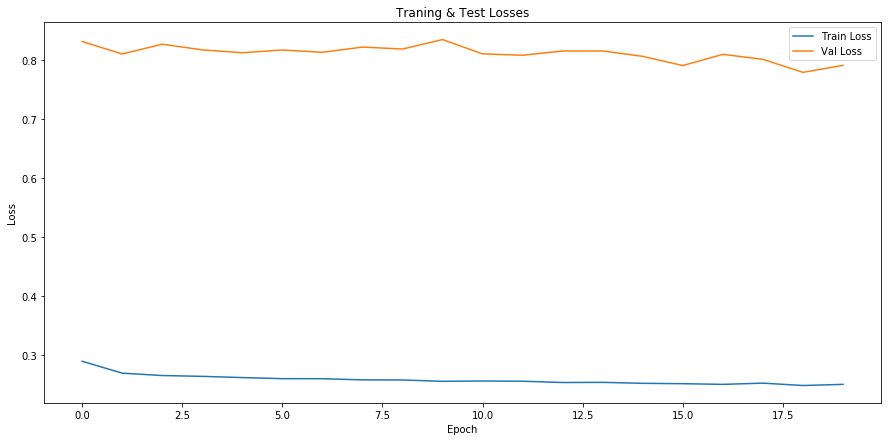

Final Train Loss: 0.24972103096767517
Final Test Loss: 0.7908651388071953


In [18]:
plot_losses(history1)

Se puede notar que a medida que avanzan los epochs, la red no logra obtener un desempeño en aumento para el conjunto de pruebas.

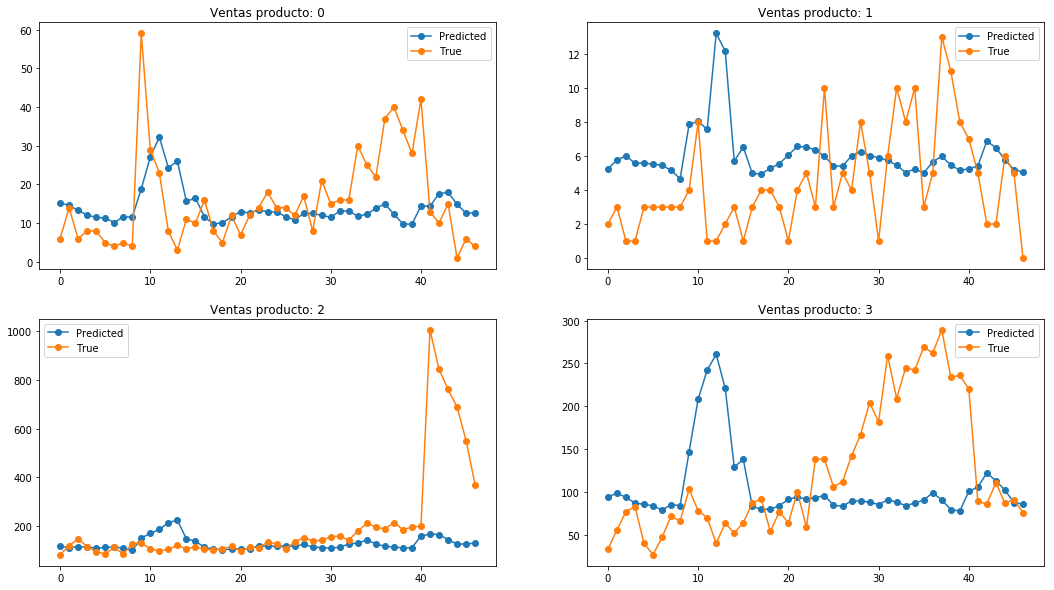

In [19]:
plot_predictions(model1, X_test, y_test)

Observando los valores predichos y reales se identifica que la red obtuvo los mejores desempeños al predecir los productos 0 y 2 ubicados en la primera columna, pero el resto de las predicciones no lograron obtener valores deseables.

In [20]:
rmses1 = rmse_f(model1, X_test, y_test)
print("Modelo 1:")
print("RMSE producto 0:",rmses1[0])
print("RMSE producto 1:",rmses1[1])
print("RMSE producto 2:",rmses1[2])
print("RMSE producto 3:",rmses1[3])
print("RMSE general:   ",rmses1[4])

Modelo 1:
RMSE producto 0: 12.239979273369904
RMSE producto 1: 4.046267493652723
RMSE producto 2: 216.46168194947063
RMSE producto 3: 96.84500266008234
RMSE general:    118.74426687830854


## Modificación

Se agrega una capa densa con activación relu antes de la capa de salida para ver si existe alguna mejora en el desempeño del modelo.

In [21]:
model3 = Sequential()
model3.add(LSTM(units=128, input_shape=(laag, X_train.shape[2]), activation='tanh', return_sequences=False))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(units=4, activation='linear'))
model3.compile(loss=pinball(0.85), optimizer='adam')
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 77,124
Trainable params: 77,124
Non-trainable params: 0
_________________________________________________________________


In [0]:
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

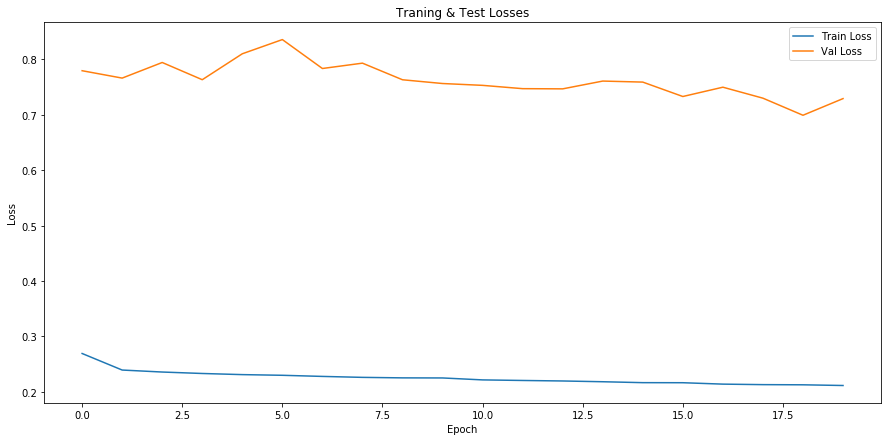

Final Train Loss: 0.211272262024424
Final Test Loss: 0.7292679067938885


In [23]:
plot_losses(history3)

Nuevamente se obtiene un resultado con una baja tasa de aprendizaje, pero con un error de pruebas un tanto mejor que el modelo anterior.

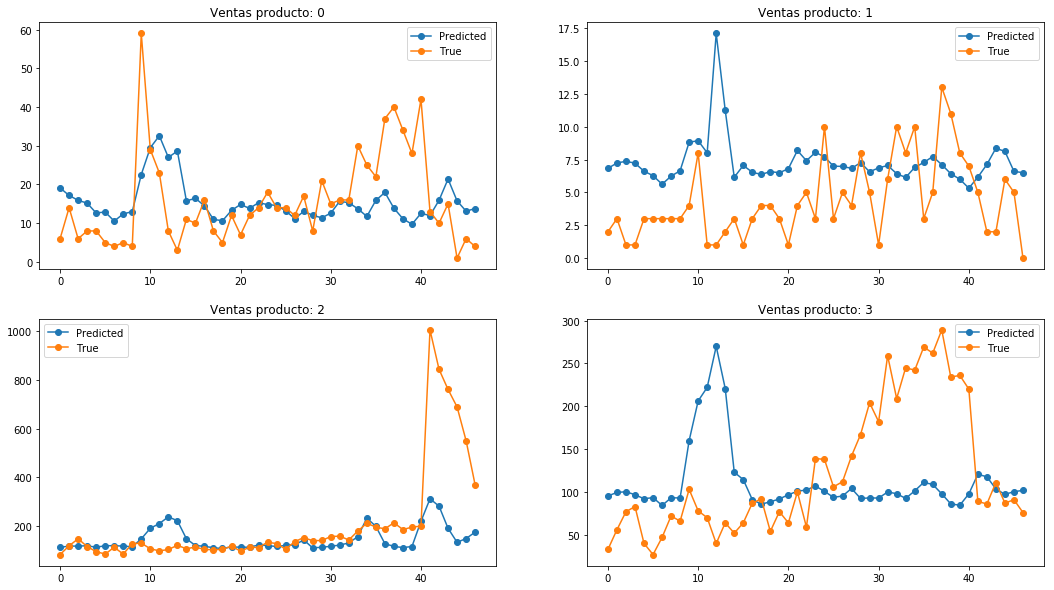

In [24]:
plot_predictions(model3, X_test, y_test)

Para este caso, se logra notar que por lo menos el tercer cuadro logra mejorar la predicción en comparación al modelo anterior, cabe destacar que la fecha que se predice en ese punto corresponde a uno de los dias cyberdays, por lo que la red fue capaz de predecir un tanto mejor las ventas de dichas fechas.

In [25]:
rmses3 = rmse_f(model3, X_test, y_test)
print("Modelo 2:")
print("RMSE producto 0:",rmses3[0])
print("RMSE producto 1:",rmses3[1])
print("RMSE producto 2:",rmses3[2])
print("RMSE producto 3:",rmses3[3])
print("RMSE general:   ",rmses3[4])

Modelo 2:
RMSE producto 0: 12.235855912966615
RMSE producto 1: 4.75319791304379
RMSE producto 2: 191.6703089827891
RMSE producto 3: 93.02877846256916
RMSE general:    106.72882697298685


## Convolucional 1D

Para intentar mejorar el desempeño se utiliza una capa de entrada convolucional 1D para intentar determinar caracteristicas relevantes sobre el conjunto.

In [26]:
model5 = Sequential()
model5.add(Conv1D(32, kernel_size=2, input_shape=(laag, X_train.shape[2]), activation='relu', padding='valid')) # or kernel=2
model5.add(LSTM(units=128, activation='tanh', return_sequences=False))
model5.add(Dense(4, activation='linear'))
model5.compile(loss=pinball(0.85), optimizer='adam')
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 32)             352       
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 83,300
Trainable params: 83,300
Non-trainable params: 0
_________________________________________________________________


In [0]:
history5 = model5.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

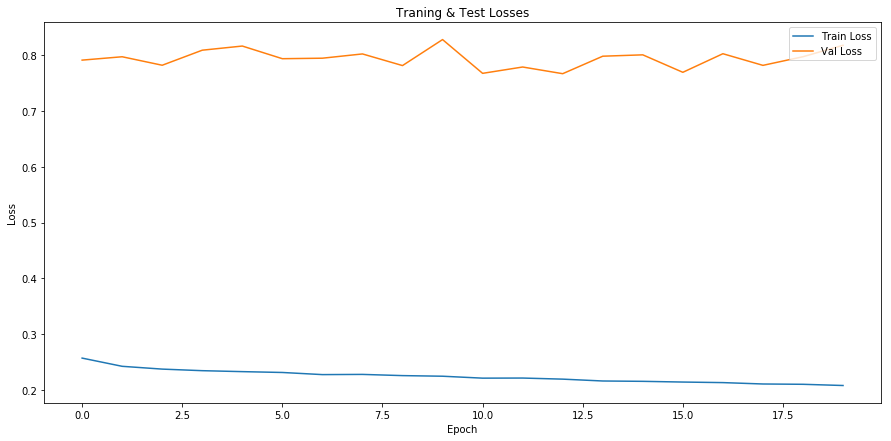

Final Train Loss: 0.2081515811185702
Final Test Loss: 0.8174772963244864


In [28]:
plot_losses(history5)

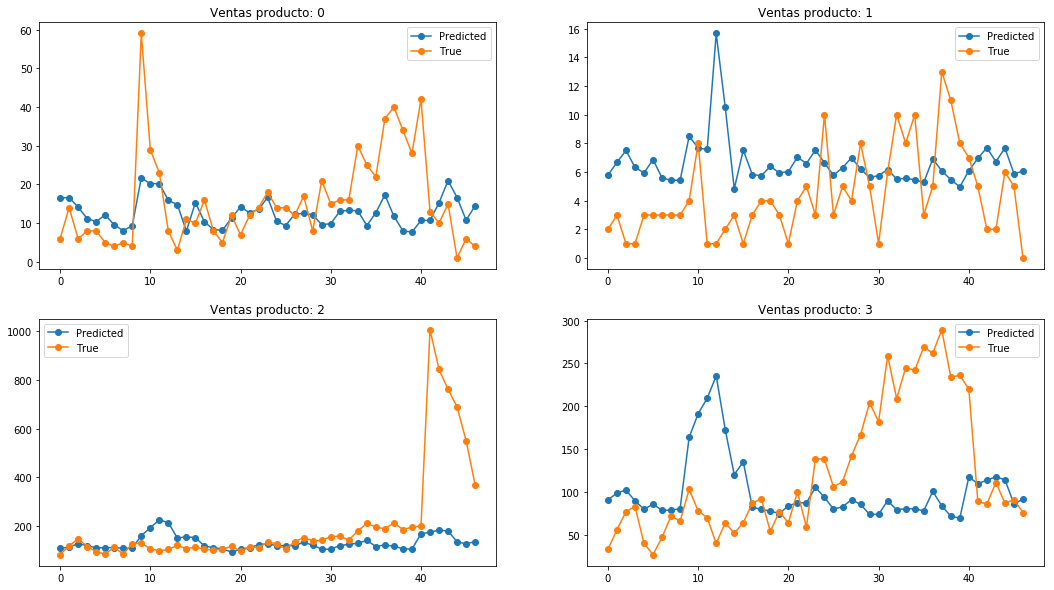

In [29]:
plot_predictions(model5, X_test, y_test)

En los 3 modelos que se han analizado hasta ahora se puede ver una similitud de las predicciones realizadas en el segundo gráfico.

In [30]:
rmses5 = rmse_f(model5, X_test, y_test)
print("Modelo 3:")
print("RMSE producto 0:",rmses5[0])
print("RMSE producto 1:",rmses5[1])
print("RMSE producto 2:",rmses5[2])
print("RMSE producto 3:",rmses5[3])
print("RMSE general:   ",rmses5[4])

Modelo 3:
RMSE producto 0: 11.925721749800015
RMSE producto 1: 4.4208032353098075
RMSE producto 2: 211.99365521519422
RMSE producto 3: 94.81122303563554
RMSE general:    116.28869700610487


## 2 Capas recurrentes

In [31]:
model6 = Sequential()
model6.add(LSTM(units=128, input_shape=(laag, X_train.shape[2]), activation='tanh',return_sequences=True, go_backwards=True))
model6.add(LSTM(units=16, activation='tanh', return_sequences=False))
model6.add(Dense(4,activation='linear'))
model6.compile(loss=pinball(0.7), optimizer='adam')
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 128)            68608     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 77,956
Trainable params: 77,956
Non-trainable params: 0
_________________________________________________________________


In [0]:
history6 = model6.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

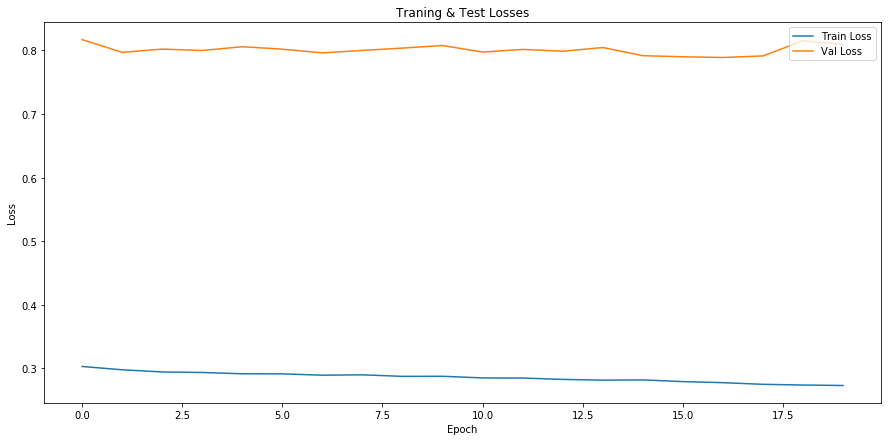

Final Train Loss: 0.27308553291416643
Final Test Loss: 0.8099326947902111


In [33]:
plot_losses(history6)

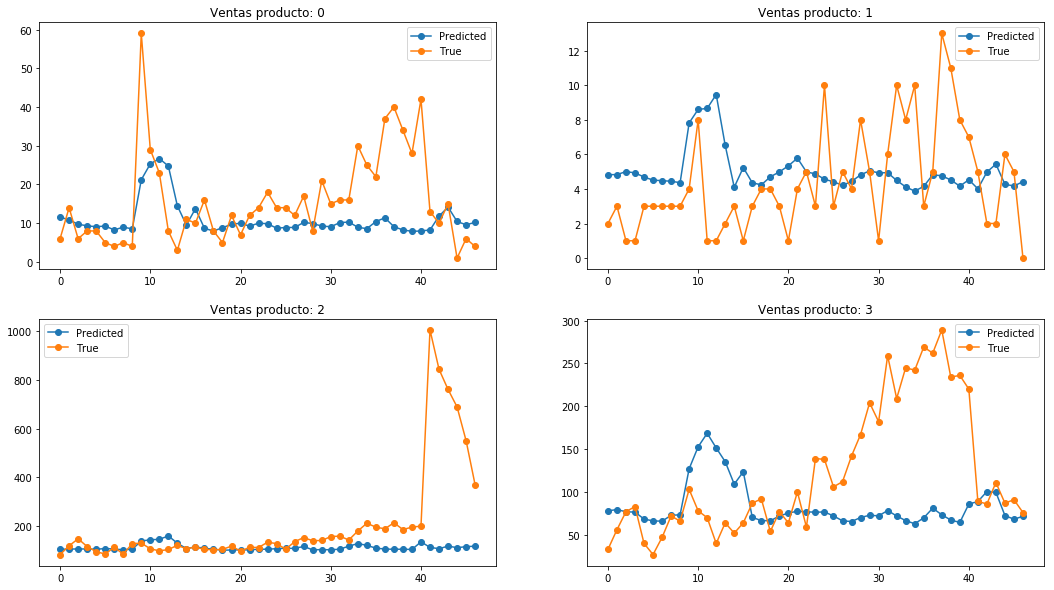

In [34]:
plot_predictions(model6, X_test, y_test)

In [35]:
rmses6 = rmse_f(model6, X_test, y_test)
print("Modelo 4:")
print("RMSE producto 0:",rmses6[0])
print("RMSE producto 1:",rmses6[1])
print("RMSE producto 2:",rmses6[2])
print("RMSE producto 3:",rmses6[3])
print("RMSE general:   ",rmses6[4])

Modelo 4:
RMSE producto 0: 12.53655172730624
RMSE producto 1: 3.5421462813212194
RMSE producto 2: 227.58236110693693
RMSE producto 3: 93.7898053594199
RMSE general:    123.24768821955224


## Modelo convolucional

Finalmente se utiliza una red como la presentada en la tarea anterior.

In [36]:
modelf = Sequential()
modelf.add(Conv1D(32, kernel_size=1, input_shape=(laag, X_train.shape[2]), activation='relu',padding='valid')) 
modelf.add(Flatten())
modelf.add(Dense(4,activation='linear'))
modelf.compile(loss=pinball(0.85), optimizer='adam')
modelf.summary()
cnn_weights = modelf.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 3, 32)             192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 388       
Total params: 580
Trainable params: 580
Non-trainable params: 0
_________________________________________________________________


In [0]:
historyf = modelf.fit(X_train, y_train, epochs=20, batch_size=5, verbose=0, validation_data=(X_test, y_test))

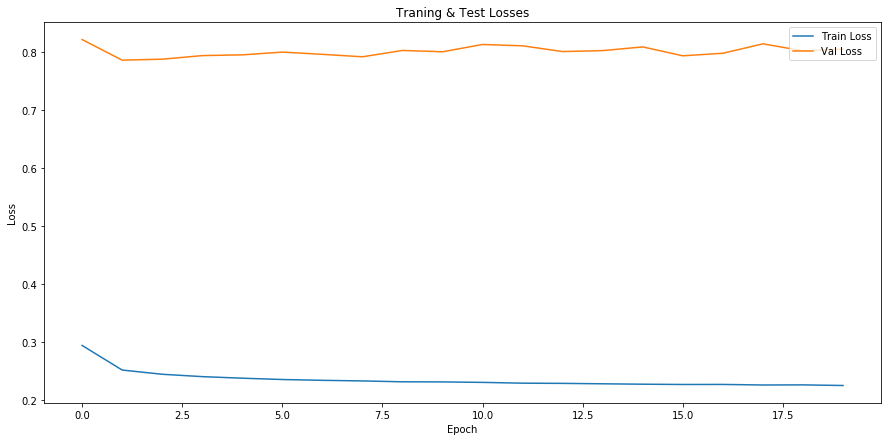

Final Train Loss: 0.22561185737681944
Final Test Loss: 0.8057003767883524


In [38]:
plot_losses(historyf)

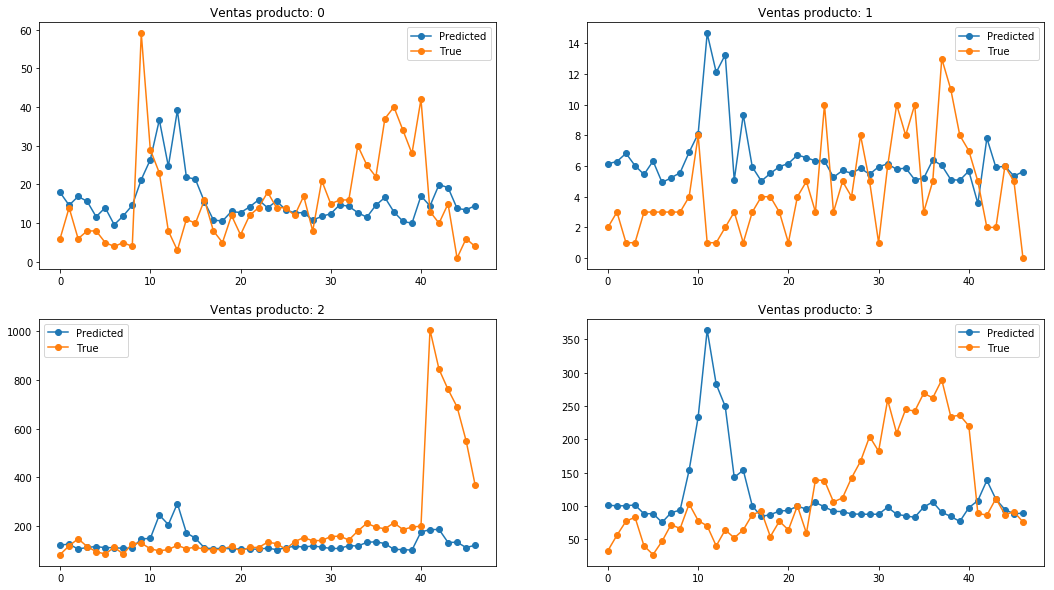

In [39]:
plot_predictions(modelf, X_test, y_test)

In [40]:
rmsesf = rmse_f(modelf, X_test, y_test)
print("Modelo F:")
print("RMSE producto 0:",rmsesf[0])
print("RMSE producto 1:",rmsesf[1])
print("RMSE producto 2:",rmsesf[2])
print("RMSE producto 3:",rmsesf[3])
print("RMSE general:   ",rmsesf[4])

Modelo F:
RMSE producto 0: 12.974124020105386
RMSE producto 1: 4.582991756083831
RMSE producto 2: 216.62763821000806
RMSE producto 3: 105.92693349501144
RMSE general:    120.76566211430728


In [41]:
print("RMSE Finales:")
print("RMSE modelo 1:",rmses1[4])
print("RMSE modelo 2:",rmses3[4])
print("RMSE modelo 3:",rmses5[4])
print("RMSE modelo 4:",rmses6[4])
print("RMSE modelo F:",rmsesf[4])

RMSE Finales:
RMSE modelo 1: 118.74426687830854
RMSE modelo 2: 106.72882697298685
RMSE modelo 3: 116.28869700610487
RMSE modelo 4: 123.24768821955224
RMSE modelo F: 120.76566211430728
